In [1]:
import torch

torch.manual_seed(1024)

In [2]:
# 定义线性模型和sigmoid函数

class Linear:
    # input:  (B, in_features)
    # output: (B, out_features)
    
    def __init__(self, in_features, out_features, bias=True):
        # 对于模型参数的初始化，故意没有做优化
        self.weight = torch.randn(in_features, out_features, requires_grad=True)  # (in_features, out_features)
        if bias:
            self.bias = torch.randn(out_features, requires_grad=True)             # (             out_features)
        else:
            self.bias = None
            
    def __call__(self, x):
        # x:        (B, in_features)
        # self.weight: (in_features, out_features)
        self.out = x @ self.weight  # (B, out_features)
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        # 返回模型参数
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]

In [6]:
l = Linear(3, 4)
x = torch.randn(5, 3)
l(x).shape

torch.Size([5, 4])

In [7]:
l.parameters()

[tensor([[ 0.6459, -0.0353,  0.5852,  0.5732],
         [-1.0110,  0.2098,  0.4153,  0.0819],
         [-0.3151, -0.5068,  0.3941,  0.3839]], requires_grad=True),
 tensor([ 0.5583, -1.1253,  1.5603,  1.9050], requires_grad=True)]

In [8]:
class Sigmoid:
    
    def __call__(self, x):
        self.out = torch.sigmoid(x)
        return self.out
    
    def parameters(self):
        return []

In [9]:
s = Sigmoid()
x = torch.randn(3, 2)
s(x).shape

torch.Size([3, 2])

In [10]:
class Perceptron:
    
    def __init__(self, in_features):
        self.ln = Linear(in_features, 1)
        self.f = Sigmoid()
        
    def __call__(self, x):
        # x: (B, in_features)
        self.out = self.f(self.ln(x))  # (B, 1)
        return self.out
    
    def parameters(self):
        return self.ln.parameters() + self.f.parameters()

In [11]:
p = Perceptron(3)
x = torch.randn(5, 3)
p(x).shape

torch.Size([5, 1])

In [12]:
class LogitRegression:
    # input:  (B, in_features)
    # output: (B, 2)
    
    def __init__(self, in_features):
        self.pos = Linear(in_features, 1)
        self.neg = Linear(in_features, 1)
        
    def __call__(self, x):
        # x: (B, in_features)
        self.out = torch.concat((self.pos(x), self.neg(x)), dim=-1)  # (B, 2)
        return self.out
    
    def parameters(self):
        return self.pos.parameters() + self.neg.parameters()

In [13]:
lr = LogitRegression(3)
x = torch.randn(5, 3)
lr(x).shape

torch.Size([5, 2])

In [14]:
logits = lr(x)
logits

tensor([[-0.4861,  0.8908],
        [-1.2695, -0.6651],
        [ 1.6948,  1.6572],
        [-0.6641, -0.0216],
        [-0.9517,  0.0869]], grad_fn=<CatBackward0>)

In [15]:
lr.pos(x)

tensor([[-0.4861],
        [-1.2695],
        [ 1.6948],
        [-0.6641],
        [-0.9517]], grad_fn=<AddBackward0>)

In [17]:
import torch.nn.functional as F

probs = F.softmax(logits, dim=-1)

In [19]:
pred = torch.argmax(probs, dim=-1)
print(probs)
print(pred)

tensor([[0.2015, 0.7985],
        [0.3533, 0.6467],
        [0.5094, 0.4906],
        [0.3447, 0.6553],
        [0.2614, 0.7386]], grad_fn=<SoftmaxBackward0>)
tensor([1, 1, 0, 1, 1])


In [21]:
loss = F.cross_entropy(logits, pred)
loss

tensor(0.4122, grad_fn=<NllLossBackward0>)

In [22]:
-probs.log()

tensor([[1.6020, 0.2250],
        [1.0403, 0.4359],
        [0.6745, 0.7121],
        [1.0651, 0.4226],
        [1.3416, 0.3030]], grad_fn=<NegBackward0>)

In [23]:
-probs.log()[range(5), pred].mean()

tensor(0.4122, grad_fn=<NegBackward0>)

In [25]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [26]:
data = make_blobs(200, centers=[[-2, -2], [2, 2]])
x, y = data

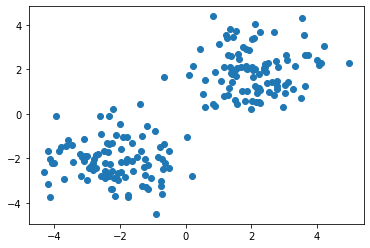

In [27]:
plt.scatter(x[:, 0], x[:, 1])

In [28]:
batch_size = 20
max_steps = 2000
learning_rate = 0.01
x, y = torch.tensor(data[0]).float(), torch.tensor(data[1])
lr = LogitRegression(2)
lossi = []

for t in range(max_steps):
    ix = (t * batch_size) % len(x)
    xx = x[ix: ix + batch_size]
    yy = y[ix: ix + batch_size]         # (20)
    logits = lr(xx)                     # (20, 2)
    loss = F.cross_entropy(logits, yy)
    loss.backward()
    with torch.no_grad():
        for p in lr.parameters():
            p -= learning_rate * p.grad
            p.grad = None
    if t % 200 == 0:
        print(f'step {t}, loss {loss.item()}')
    lossi.append(loss.item())

step 0, loss 0.26484909653663635
step 200, loss 0.08326209336519241
step 400, loss 0.051809437572956085
step 600, loss 0.038577087223529816
step 800, loss 0.031144658103585243
step 1000, loss 0.026323309168219566
step 1200, loss 0.022914284840226173
step 1400, loss 0.020361438393592834
step 1600, loss 0.01836979016661644
step 1800, loss 0.016767438501119614


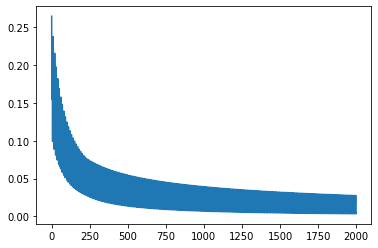

In [29]:
plt.plot(lossi)